# Clustering via Affinity Propagation

In [4]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns

from sklearn.cluster import AffinityPropagation
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler

file_path_PCA = "../../reduced_data/joueurs_ligue1_PCA_custom.csv"
file_path_tSNE = "../../reduced_data/joueurs_ligue1_tSNE_custom_GK.csv"
file_path_ISOMAP = "../../reduced_data/joueurs_ligue1_ISOMap_raw.csv"
file_path_UMAP = "../../reduced_data/joueurs_ligue1_2024_2025_clean_per90_umap3d_best_embedding.csv"

data_PCA= pd.read_csv(file_path_PCA, encoding="utf-8")
data_tSNE = pd.read_csv(file_path_tSNE, encoding="utf-8")
data_ISOMAP = pd.read_csv(file_path_ISOMAP, encoding="utf-8")
data_UMAP = pd.read_csv(file_path_UMAP, encoding="utf-8")
print(data_PCA.head(1))

       pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0  6.859919 -3.198215  0.554745 -3.352881  1.180055  0.031028  0.307974   

       pca8     pca9     pca10  ...     pca28     pca29     pca30     pca31  \
0 -0.606673  1.00074  0.882777  ...  0.611043 -0.057373 -0.165505 -0.323732   

      pca32     pca33     pca34    player_name  equipe  positions  
0 -1.092719  0.680418  0.138402  Jordan Lefort  Angers         DF  

[1 rows x 37 columns]


## Data Preparation : standardisation + columns removal

In [5]:
X_PCA = data_PCA.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_tSNE = data_tSNE.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_ISOMAP = data_ISOMAP.drop(columns=['player_name', 'equipe', 'positions']).copy()
X_UMAP = data_UMAP.drop(columns=['player_name', 'equipe', 'positions','player_id','player_country_code', 'age']).copy()

scaler = StandardScaler()
X_PCA = scaler.fit_transform(X_PCA) 
X_tSNE = scaler.fit_transform(X_tSNE)
X_ISOMAP = scaler.fit_transform(X_ISOMAP) 
X_UMAP = scaler.fit_transform(X_UMAP) 
print(X_UMAP[1])

[ 0.07147241 -0.32309249  1.04432427]


## GridSearch Analysis

In [18]:
def affinity_gridsearch(X, damping_values=np.linspace(0.5, 0.95, 10), preference_values=np.linspace(-200, -20, 10) , random_state = 42):
    
    results = []

    if preference_values is None:
        median = np.median(-np.linalg.norm(X[:, None] - X[None, :], axis=2)**2)
        preference_values = np.linspace(median*1.5, median*0.5, 5)

    print(f"Preference values : {preference_values}")

    for damping in damping_values:
        for pref in preference_values:
            try:
                model = AffinityPropagation(damping=damping, preference=pref, random_state=42)
                model.fit(X)
                labels = model.labels_

                if len(np.unique(labels)) < 2:
                    # Skip if only one cluster
                    continue
                sil_score = silhouette_score(X, labels)
                db_score = davies_bouldin_score(X, labels)
                ch_score = calinski_harabasz_score(X, labels)

                results.append({
                    'damping': round(damping, 3),
                    'preference': round(pref, 3),
                    'n_clusters': len(np.unique(labels)),
                    'silhouette_score': sil_score,
                    'davies_bouldin': db_score,
                    'calinski_harabasz': ch_score,
                })

            except Exception as e:
                print(f"[✗] Damping: {damping}, Preference: {pref} -> Failed: {e}")

    results_df = pd.DataFrame(results)

    metrics = ['silhouette_score', 'davies_bouldin', 'calinski_harabasz', 'n_clusters']
    pivot_df = results_df.pivot(index='damping', columns='preference')[metrics]

    flat_df = pivot_df.swaplevel(axis=1).sort_index(axis=1)
    flat_df.columns = [f"{cov}_{metric}" for cov, metric in flat_df.columns]

    # Classements sur chaque indicateur
    rank_df = pd.DataFrame(index=flat_df.index)

    for col in flat_df.columns:
        metric = col.split("_", 1)[1]
        if metric in ['n_clusters', 'davies_bouldin']:
            rank_df[col] = flat_df[col].rank(method='min', ascending=True)
        else:
            rank_df[col] = flat_df[col].rank(method='min', ascending=False)
        
    print("\n📊 Results (combinaisons damping / preference):")
    print("=========SilouhetteScore===========")
    print(pivot_df["silhouette_score"])
    print("=========N_clusters===========")
    print(pivot_df["n_clusters"])
    print("=========DaviesBouldin===========")
    print(pivot_df["davies_bouldin"])
    print("=========CalinskiHarabasz===========")
    print(pivot_df["calinski_harabasz"])

    """
    print("\n📊 Avg rankings:")
    print(rank_df)
    """
    
    return results_df, rank_df


print("="*80)
print("="*30, "PCA : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_PCA, random_state=42)

print("="*80)
print("="*30, "t-SNE : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_tSNE, random_state=42)

print("="*80)
print("="*30, "ISOMAP : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_ISOMAP, random_state=42)

print("="*80)
print("="*30, "UMAP : ", "="*30)
print("="*80)
_, _ = affinity_gridsearch(X_UMAP, random_state=42)

============================== PCA :  ==============================
Preference values : [-400.         -377.77777778 -355.55555556 -333.33333333 -311.11111111
 -288.88888889 -266.66666667 -244.44444444 -222.22222222 -200.        ]

📊 Results (combinaisons damping / preference):
=========SilouhetteScore===========
preference  -400.000  -377.778  -355.556  -333.333  -311.111  -288.889  \
damping                                                                  
0.50        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.55        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.60        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.65        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.70        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.75        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.80        0.001887  0.001887  0.001887  0.001887  0.001887  0.001887   
0.85        0.0018

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.5, Preference: -377.77777777777777 -> Failed: Number of labels is 356. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library

[✗] Damping: 0.5, Preference: -266.6666666666667 -> Failed: Number of labels is 356. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.5, Preference: -222.22222222222223 -> Failed: Number of labels is 356. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library


📊 Results (combinaisons damping / preference):
=========SilouhetteScore===========
preference  -400.000  -377.778  -355.556  -333.333  -311.111  -288.889  \
damping                                                                  
0.50        0.015055       NaN  0.174221  0.014763  0.012491  0.174125   
0.55        0.006019  0.059589  0.049480  0.317484  0.030241  0.359615   
0.60        0.355906  0.343837  0.388225  0.365191  0.388225  0.359615   
0.65        0.343837  0.355906  0.317484  0.388225  0.317484  0.365191   
0.70        0.365191  0.365191  0.355906  0.355906  0.342211  0.365191   
0.75        0.359615  0.388225  0.365191  0.355906  0.317484  0.317484   
0.80        0.365191  0.365191  0.365191  0.365191  0.365191  0.365191   
0.85        0.365191  0.388225  0.365191  0.365191  0.365191  0.388225   
0.90        0.388225  0.365191  0.365191       NaN  0.359615  0.388225   
0.95        0.365191  0.365191  0.365191       NaN  0.359615  0.388225   

preference  -266.667  -244.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:164: ConvergenceWarning:

Affinity propagation did not converge and this model will not have any cluster centers.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.5, Preference: -333.33333333333337 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.5, Preference: -311.1111111111111 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)
[✗] Damping: 0.5, Preference: -288.8888888888889 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.5, Preference: -244.44444444444446 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.55, Preference: -400.0 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.55, Preference: -355.55555555555554 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:164: ConvergenceWarning:

Affinity propagation did not converge and this model will not have any cluster centers.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.55, Preference: -266.6666666666667 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/cluster/_affinity_propagation.py:142: ConvergenceWarning:

Affinity propagation did not converge, this model may return degenerate cluster centers and labels.



[✗] Damping: 0.6, Preference: -355.55555555555554 -> Failed: Number of labels is 333. Valid values are 2 to n_samples - 1 (inclusive)

📊 Results (combinaisons damping / preference):
=========SilouhetteScore===========
preference  -400.000  -377.778  -355.556  -333.333  -311.111  -288.889  \
damping                                                                  
0.50        0.127365  0.017683       NaN       NaN       NaN       NaN   
0.55             NaN  0.127275       NaN       NaN  0.138472  0.405575   
0.60        0.004546  0.405575       NaN  0.429953  0.427072  0.427072   
0.65             NaN       NaN  0.405575  0.405575  0.427072  0.371443   
0.70        0.420961  0.405575  0.427072  0.405575  0.405575  0.427072   
0.75        0.427072  0.405575  0.405575  0.429953  0.427072  0.427072   
0.80        0.405575  0.405575  0.405575  0.405575  0.427072  0.427072   
0.85        0.427072  0.405575  0.405575  0.405575  0.405575  0.405575   
0.90        0.427072  0.427072  0.427072  

## Run Affinity Propagation

In [21]:
def run_affinity(X, data, damping =0.9, preference=None, random_state = 42, name=""):

    aff = AffinityPropagation(damping=damping, preference=preference, random_state=42)
    aff.fit(X)
    labels = aff.labels_

    df = pd.DataFrame(X, columns=[f'{name}_{i+1}' for i in range(X.shape[1])])
    df["cluster"] = labels

    meta_cols = ['player_name', 'equipe', 'positions']
    df_meta = data[meta_cols].copy()
    df_meta.index = df.index 
    df = df_meta.join(df)

    return df, aff

X_aff_PCA_best, aff_PCA_best = run_affinity(X_PCA, data_PCA, damping = 0.70 , preference = -120 , random_state = 42, name = "PCA")
X_aff_tSNE_best, aff_tSNE_best = run_affinity(X_tSNE, data_tSNE, damping = 0.75 , preference = -40 , random_state = 42, name = "tsne") #Alternatives ac - clusters vers params comme PCA
X_aff_ISOMAP_best, aff_ISOMAP_best = run_affinity(X_ISOMAP, data_ISOMAP, damping = 0.85 , preference = -80 , random_state = 42, name = "isomap")
X_aff_UMAP_best, aff_UMAP_best = run_affinity(X_UMAP, data_UMAP, damping = 0.85 , preference = -60 , random_state = 42, name = "UMAP")

## Results Display

============RESULTS EN 3D===============


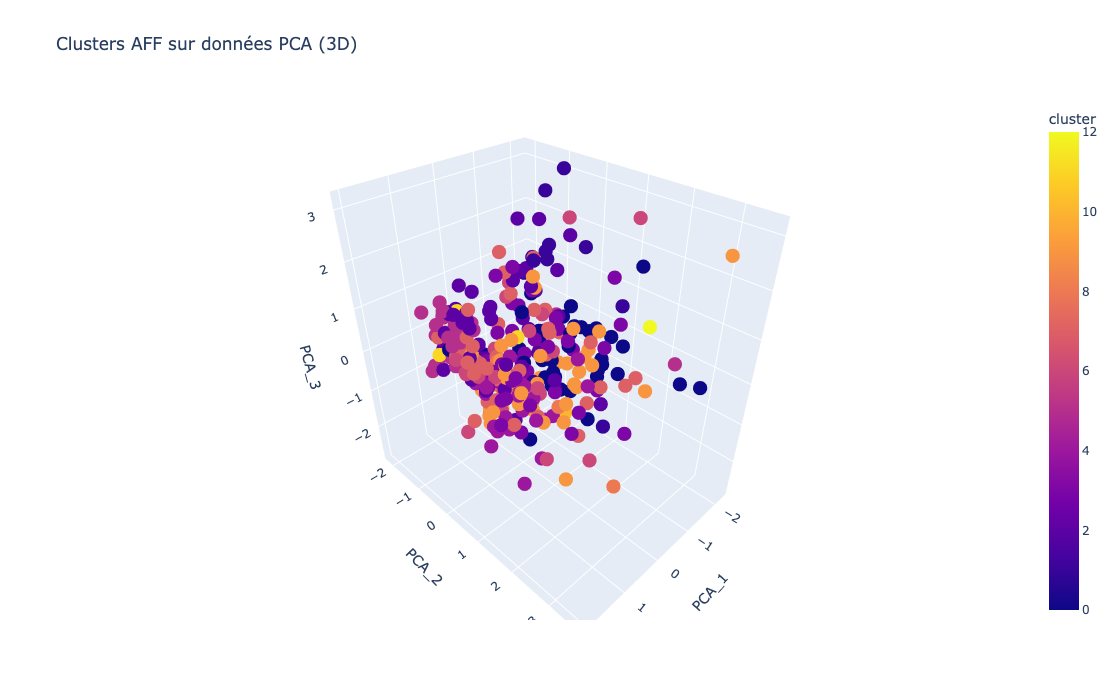

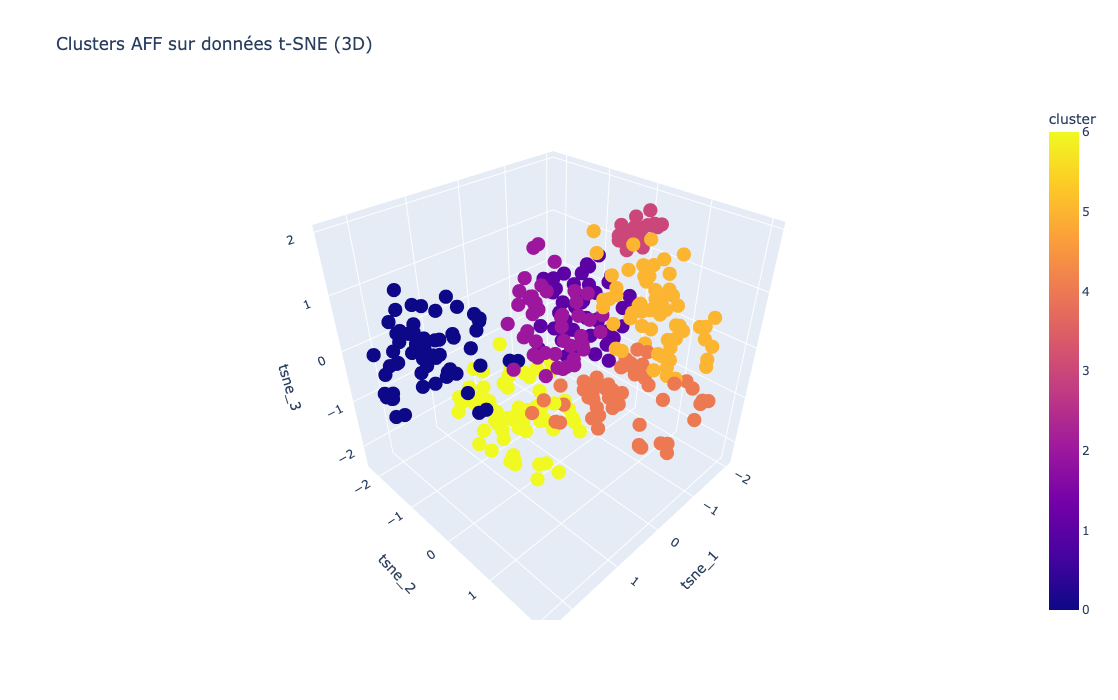

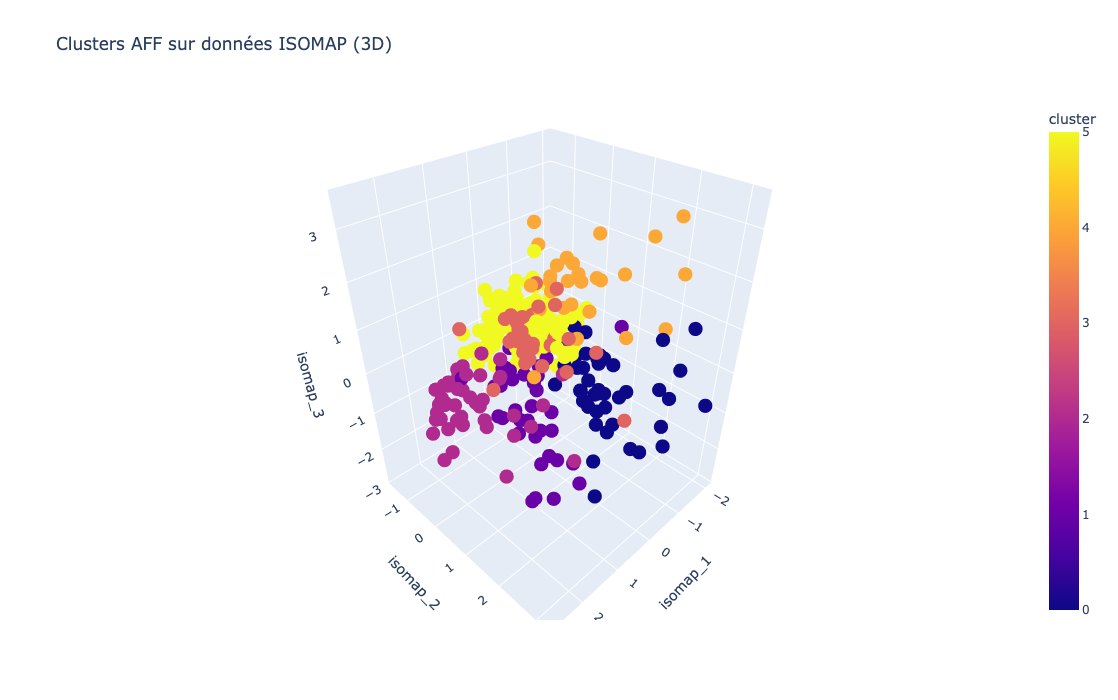

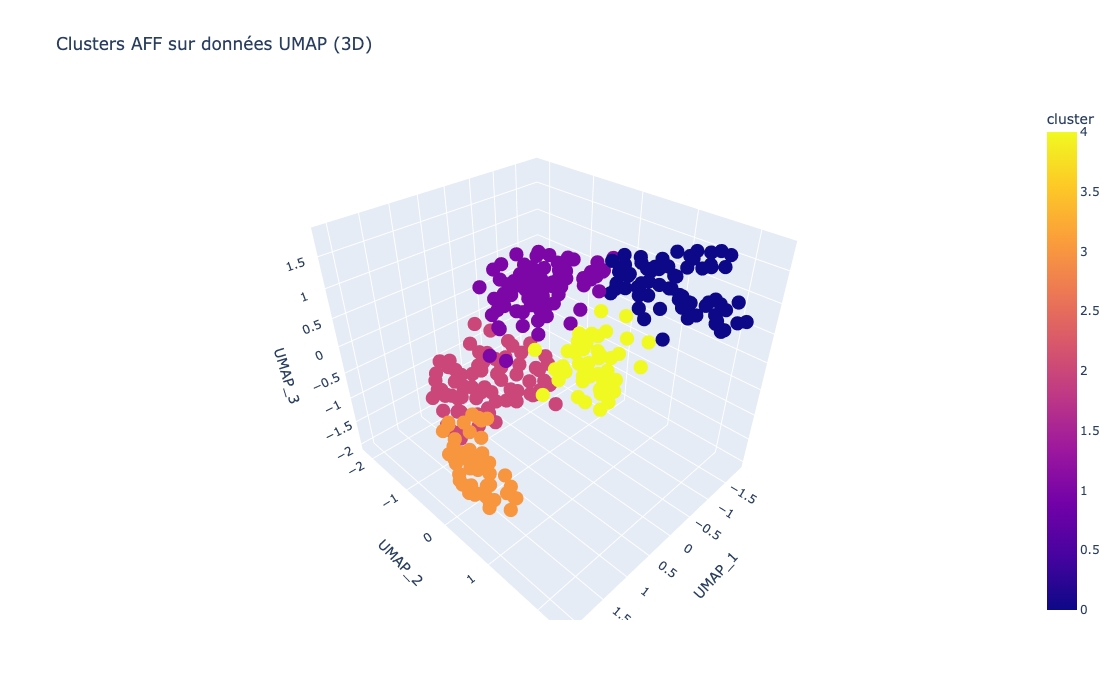

In [22]:
def print_results(X, column1, column2, data_name) :
    fig = px.scatter(
        X,
        x= column1, 
        y= column2, 
        color='cluster', 
        hover_data=['player_name', 'positions'],  # ce qui s'affiche au survol
        title=f"Clusters AFF sur données {data_name}",
        width=800, 
        height=600,
        color_discrete_sequence= None
    )
    fig.show()

def print_results_3d(X, column1, column2, column3, data_name):
    fig = px.scatter_3d(
        X,
        x=column1,
        y=column2,
        z=column3,
        color='cluster',
        hover_data=['player_name', 'positions'],  # info au survol
        title=f"Clusters AFF sur données {data_name} (3D)",
        width=900,
        height=700,
        color_discrete_sequence=None
    )
    fig.show()

"""
print("="*60)
print("============RESULTS EN 2D===============")
print("="*60)
print_results(X_aff_PCA_best, "PCA_1", "PCA_2", "PCA")
print_results(X_aff_tSNE_best, "tsne_1", "tsne_2", "t-SNE")
print_results(X_aff_ISOMAP_best, "isomap_1", "isomap_2", "ISOMAP")
print_results(X_aff_UMAP_best, "UMAP_1", "UMAP_2", "UMAP")
"""

print("="*60)
print("============RESULTS EN 3D===============")
print("="*60)
print_results_3d(X_aff_PCA_best, "PCA_1", "PCA_2", "PCA_3", "PCA")
print_results_3d(X_aff_tSNE_best, "tsne_1", "tsne_2", "tsne_3", "t-SNE")
print_results_3d(X_aff_ISOMAP_best, "isomap_1", "isomap_2", "isomap_3", "ISOMAP")
print_results_3d(X_aff_UMAP_best, "UMAP_1", "UMAP_2", "UMAP_3", "UMAP")